In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of images in the train set :  2028
Number of images in the test set ;  1208
Number of images in prediction set :  0


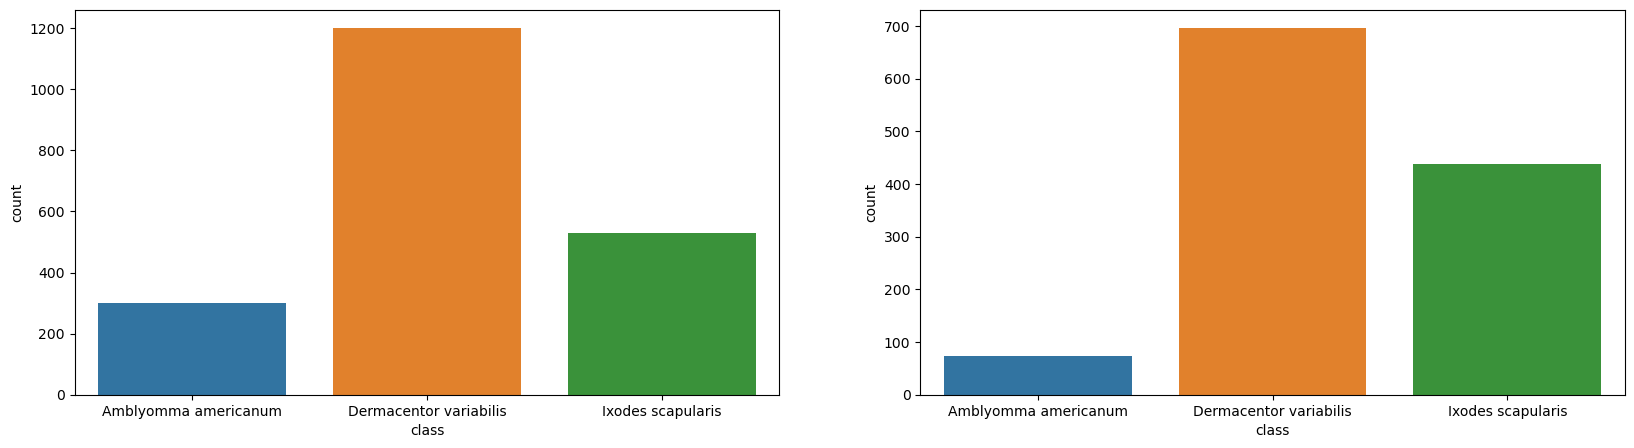

In [2]:
root_path = 'C:/Users/ShepDaddy/Documents/GitHub/scantAI/'
train_pred_test_folders = os.listdir(root_path)


'''
seg_train_folders = '../input/intel-image-classification/seg_train/seg_train/' #one more seg_train folder within
seg_test_folders = '../input/intel-image-classification/seg_test/seg_test/'
seg_pred_folders = '../input/intel-image-classification/seg_pred/seg_pred/'
'''
seg_train_folders = 'C:/Users/ShepDaddy/Documents/GitHub/scantAI/subbed/subbeddeer/train/' #one more seg_train folder within
seg_test_folders = 'C:/Users/ShepDaddy/Documents/GitHub/scantAI/subbed/subbeddeer/validation/'
seg_pred_folders = 'C:/Users/ShepDaddy/Documents/GitHub/scantAI/new_dataset/seg_pred/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [3]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot((acc), label='Training Accuracy')
    sns.lineplot((val_acc),label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot((loss),label='Training Loss')
    sns.lineplot((val_loss), label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [4]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 2028 images belonging to 3 classes.
Found 1208 images belonging to 3 classes.


In [5]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Amblyomma americanum': 0, 'Dermacentor variabilis': 1, 'Ixodes scapularis': 2}
{0: 'Amblyomma americanum', 1: 'Dermacentor variabilis', 2: 'Ixodes scapularis'}


In [6]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

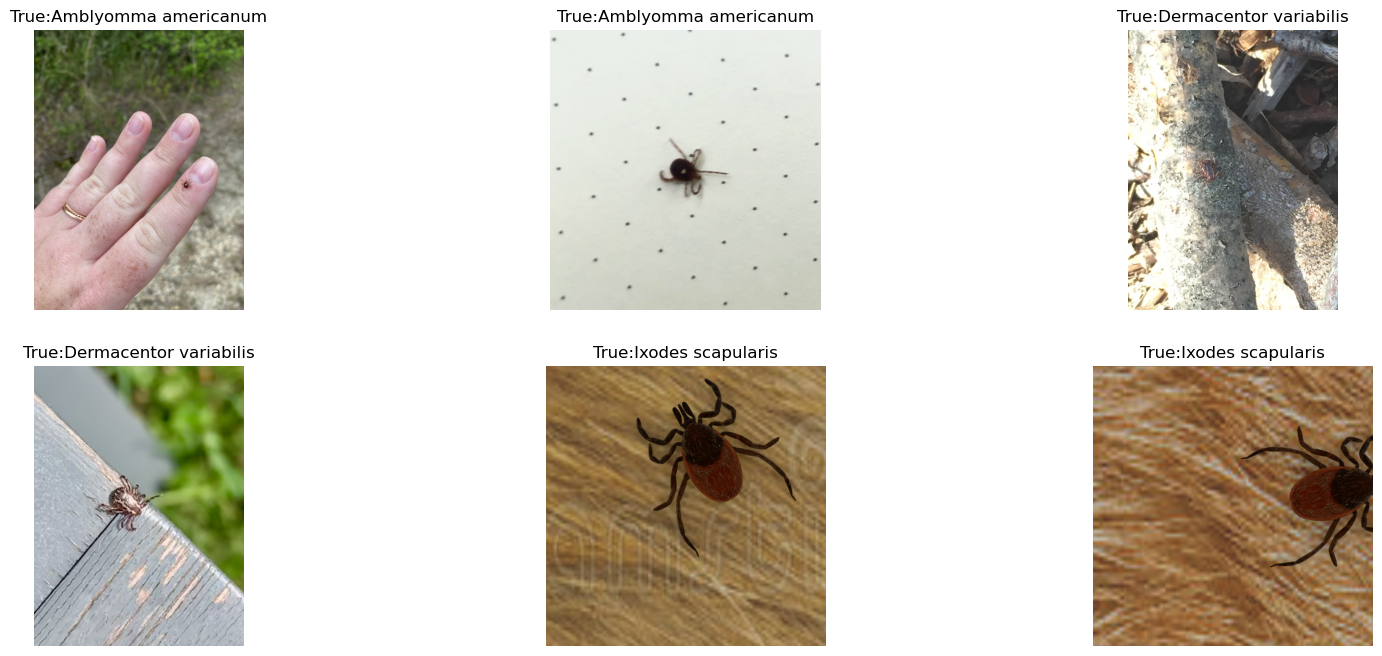

In [17]:
show_few_images(2)

In [18]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 30
vgg_epoch = 30
resnet_epoch = 30
inception_epoch = 30

In [19]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(3,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

In [24]:
# plot_model(benchmark_model, to_file='model.png',show_shapes=True, show_layer_names=True)
# from IPython.display import FileLink
# FileLink(r'./resnet50_-saved-model-08-acc-0.75.hdf5')

In [20]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.2782 - acc: 0.5947
Epoch 1: val_acc improved from -inf to 0.58195, saving model to bench_mark_-model-01-0.58.hdf5
64/64 [==============================] - 76s 1s/step - loss: 1.2782 - acc: 0.5947 - val_loss: 1.1218 - val_acc: 0.5820 - lr: 0.0010
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.7744 - acc: 0.6879
Epoch 2: val_acc did not improve from 0.58195
64/64 [==============================] - 73s 1s/step - loss: 0.7744 - acc: 0.6879 - val_loss: 1.7277 - val_acc: 0.5770 - lr: 0.0010
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.6357 - acc: 0.7525
Epoch 3: val_acc did not improve from 0.58195
64/64 [==============================] - 71s 1s/step - loss: 0.6357 - acc: 0.7525 - val_loss: 2.5248 - val_acc: 0.5596 - lr: 0.0010
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 0.5433 - acc: 0.7801
Epoch 4: val_acc did not improve from 0.58195
64/64 [========

OSError: [Errno 22] Unable to create file (unable to open file: name = 'bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

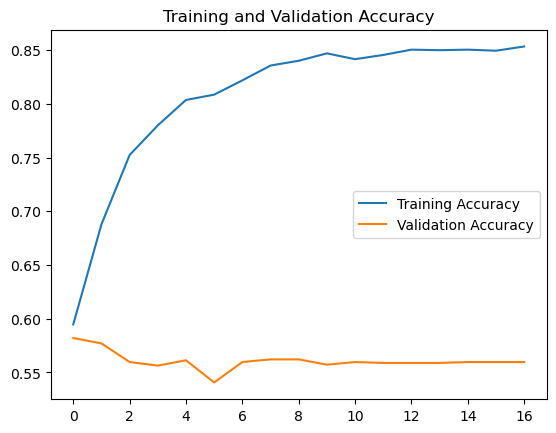

<Figure size 640x480 with 0 Axes>

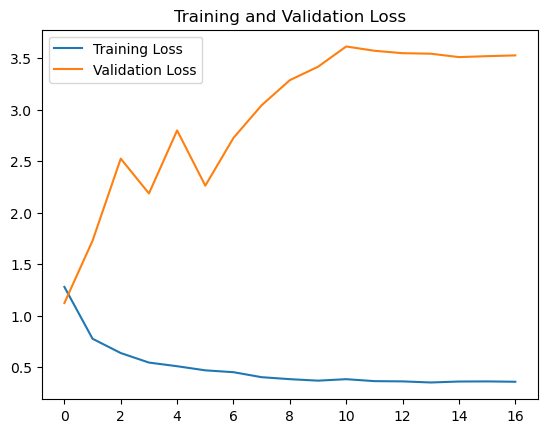

<Figure size 640x480 with 0 Axes>

In [21]:
filepath = "bench_mark_-model-11.hdf5"
benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.8267 - acc: 0.6563
Epoch 1: val_acc improved from -inf to 0.57119, saving model to vgg_16_-saved-model-01-acc-0.57.hdf5
64/64 [==============================] - 98s 2s/step - loss: 0.8267 - acc: 0.6563 - val_loss: 1.1478 - val_acc: 0.5712
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.5899 - acc: 0.7840
Epoch 2: val_acc improved from 0.57119 to 0.58030, saving model to vgg_16_-saved-model-02-acc-0.58.hdf5
64/64 [==============================] - 97s 2s/step - loss: 0.5899 - acc: 0.7840 - val_loss: 1.4136 - val_acc: 0.5803
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.5156 - acc: 0.8077
Epoch 3: val_acc improved from 0.58030 to 0.58775, saving model to vgg_16_-saved-model-03-acc-0.59.hdf5
64/64 [==============================] - 96s 2s/step - loss: 0.5156 - acc: 0.8077 - val_loss: 1.6812 - val_acc: 0.5877
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss:

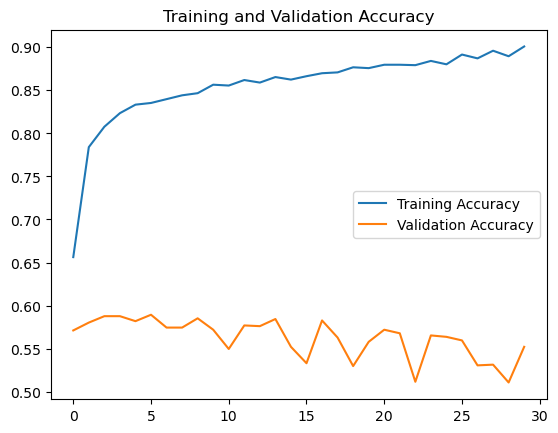

<Figure size 640x480 with 0 Axes>

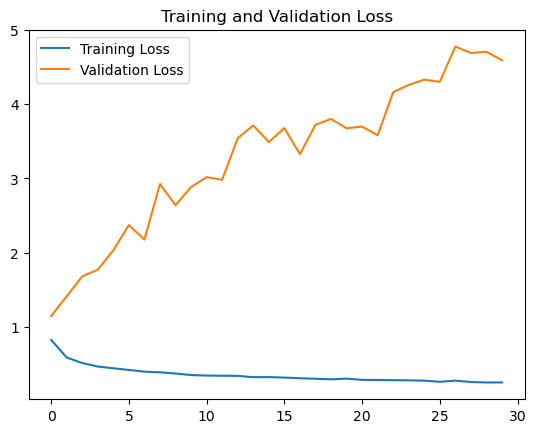

<Figure size 640x480 with 0 Axes>

In [22]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

In [23]:
filepath = "bench_mark_-VGG16-11.hdf5"
vgg16_final_model.save(filepath)


c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.9030 - acc: 0.7899
Epoch 1: val_acc improved from -inf to 0.57616, saving model to resnet50-saved-model-01-val_acc-0.58.hdf5
64/64 [==============================] - 127s 2s/step - loss: 0.9030 - acc: 0.7899 - val_loss: 1.0738 - val_acc: 0.5762 - lr: 0.0100
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.3321 - acc: 0.8545
Epoch 2: val_acc did not improve from 0.57616
64/64 [==============================] - 124s 2s/step - loss: 0.3321 - acc: 0.8545 - val_loss: 1.5644 - val_acc: 0.5762 - lr: 0.0100
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.2402 - acc: 0.9068
Epoch 3: val_acc did not improve from 0.57616
64/64 [==============================] - 124s 2s/step - loss: 0.2402 - acc: 0.9068 - val_loss: 2.0563 - val_acc: 0.5762 - lr: 0.0100
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 0.1748 - acc: 0.9315
Epoch 4: val_acc did not improve from 0.57616
6

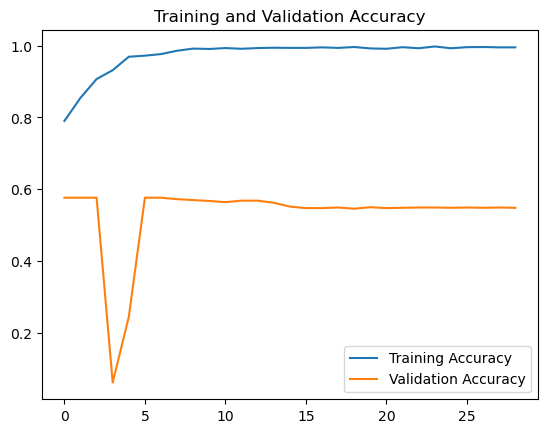

<Figure size 640x480 with 0 Axes>

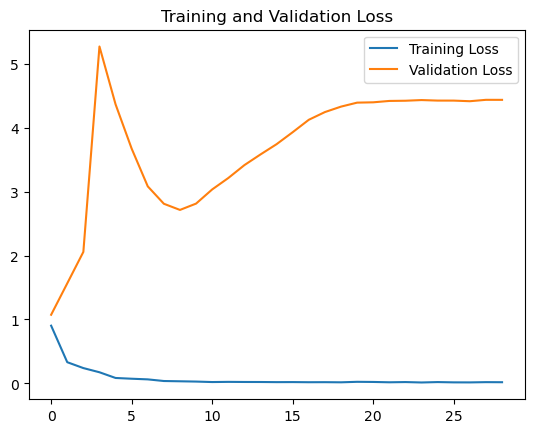

<Figure size 640x480 with 0 Axes>

In [24]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.9939 - accuracy: 0.6006
Epoch 1: accuracy improved from -inf to 0.60059, saving model to inceptionv3_-saved-model-01-loss-0.99.hdf5
64/64 [==============================] - 78s 1s/step - loss: 0.9939 - accuracy: 0.6006 - val_loss: 1.2953 - val_accuracy: 0.5828
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.7313
Epoch 2: accuracy improved from 0.60059 to 0.73126, saving model to inceptionv3_-saved-model-02-loss-0.70.hdf5
64/64 [==============================] - 74s 1s/step - loss: 0.7027 - accuracy: 0.7313 - val_loss: 1.5787 - val_accuracy: 0.5720
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.7821
Epoch 3: accuracy improved from 0.73126 to 0.78205, saving model to inceptionv3_-saved-model-03-loss-0.59.hdf5
64/64 [==============================] - 73s 1s/step - loss: 0.5889 - accuracy: 0.7821 - val_loss: 1.4512 - val_accuracy: 0.5820
E

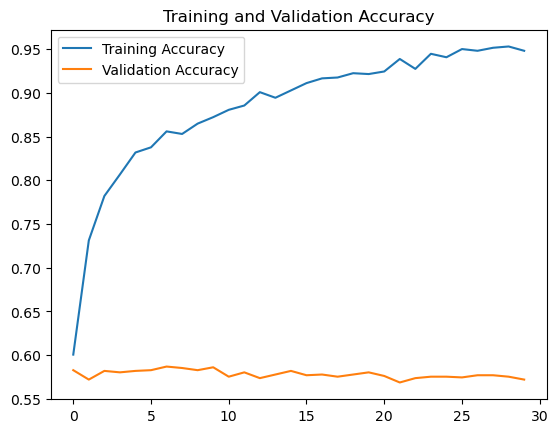

<Figure size 640x480 with 0 Axes>

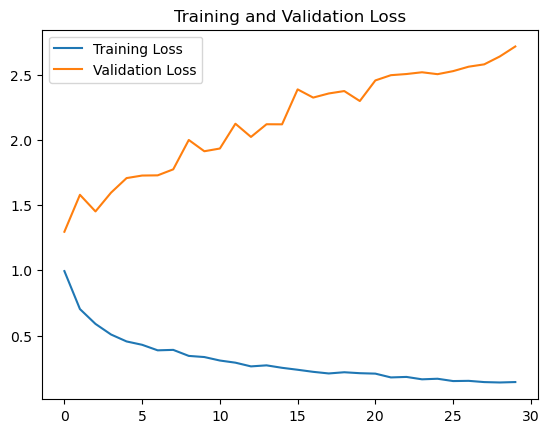

<Figure size 640x480 with 0 Axes>

In [25]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

### Combining the best models of VGG16, Resnet50 & InceptionV3

In [8]:
vgg_best_model = keras.models.load_model('C:/Users/ShepDaddy/Documents/GitHub/scantAI/Root_/vgg_16_-saved-model-12-acc-0.60.hdf5')
resnet_best_model = keras.models.load_model('C:/Users/ShepDaddy/Documents/GitHub/scantAI/OneClass/Models/subbed_resnet50-saved-model-01-val_acc-0.58.hdf5')
inception_best_model = keras.models.load_model('C:/Users/ShepDaddy/Documents/GitHub/scantAI/Root_/inceptionv3_-saved-model-59-loss-0.13.hdf5')
benchmark_model = keras.models.load_model('C:/Users/ShepDaddy/Documents/GitHub/scantAI/Root_/bench_mark_-model-05-0.58.hdf5')
#vgg_best_model = vgg16_final_model 
#resnet_best_model = resnet50_x_final_model
#inception_best_model = InceptionV3_x_final_model 

In [9]:
#import image
import cv2

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))

        #img = Image.open(path).resize((150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 118ms/step


In [10]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.5778145695364238
                        precision    recall  f1-score   support

  Amblyomma americanum       0.00      0.00      0.00        74
Dermacentor variabilis       0.58      1.00      0.73       696
     Ixodes scapularis       0.43      0.01      0.01       438

              accuracy                           0.58      1208
             macro avg       0.34      0.34      0.25      1208
          weighted avg       0.49      0.58      0.43      1208



c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


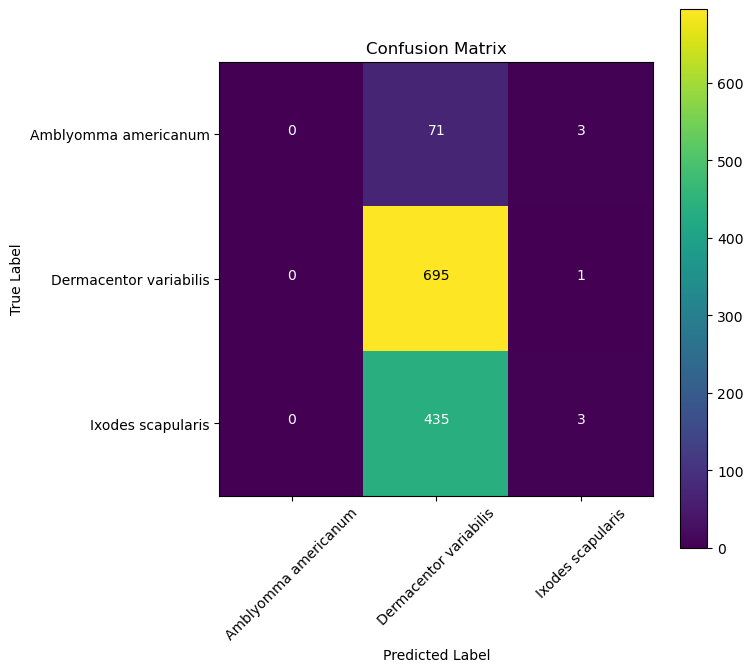

In [29]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

Model Accuracy 0.6572847682119205
                        precision    recall  f1-score   support

  Amblyomma americanum       0.09      0.01      0.02        74
Dermacentor variabilis       0.71      0.79      0.75       696
     Ixodes scapularis       0.58      0.55      0.57       438

              accuracy                           0.66      1208
             macro avg       0.46      0.45      0.45      1208
          weighted avg       0.62      0.66      0.64      1208



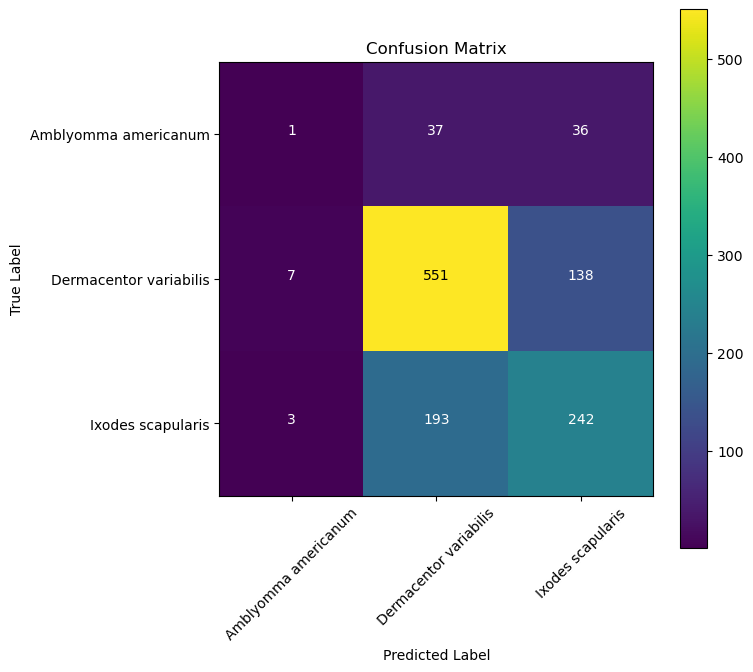

In [30]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.597682119205298
                        precision    recall  f1-score   support

  Amblyomma americanum       0.19      0.04      0.07        74
Dermacentor variabilis       0.63      0.84      0.72       696
     Ixodes scapularis       0.51      0.30      0.38       438

              accuracy                           0.60      1208
             macro avg       0.44      0.40      0.39      1208
          weighted avg       0.56      0.60      0.56      1208



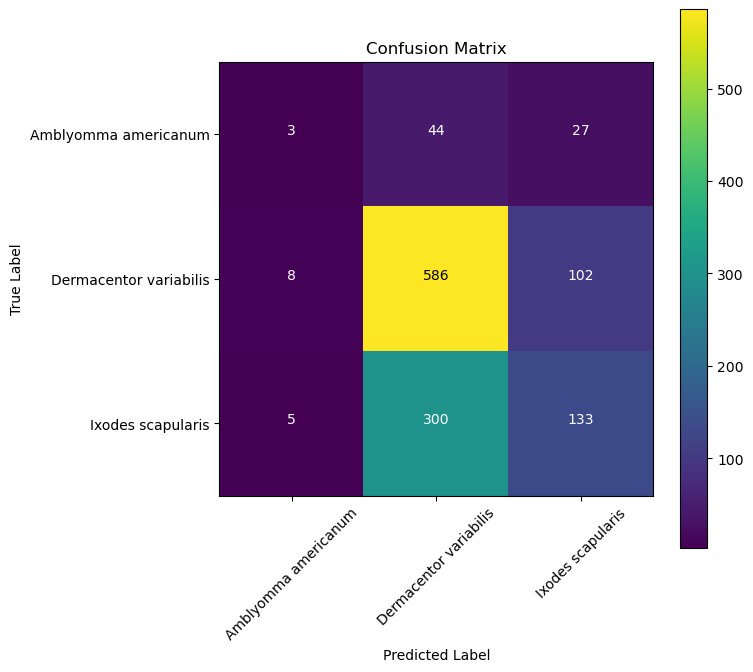

In [31]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.5761589403973509
                        precision    recall  f1-score   support

  Amblyomma americanum       0.00      0.00      0.00        74
Dermacentor variabilis       0.58      1.00      0.73       696
     Ixodes scapularis       0.00      0.00      0.00       438

              accuracy                           0.58      1208
             macro avg       0.19      0.33      0.24      1208
          weighted avg       0.33      0.58      0.42      1208



c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


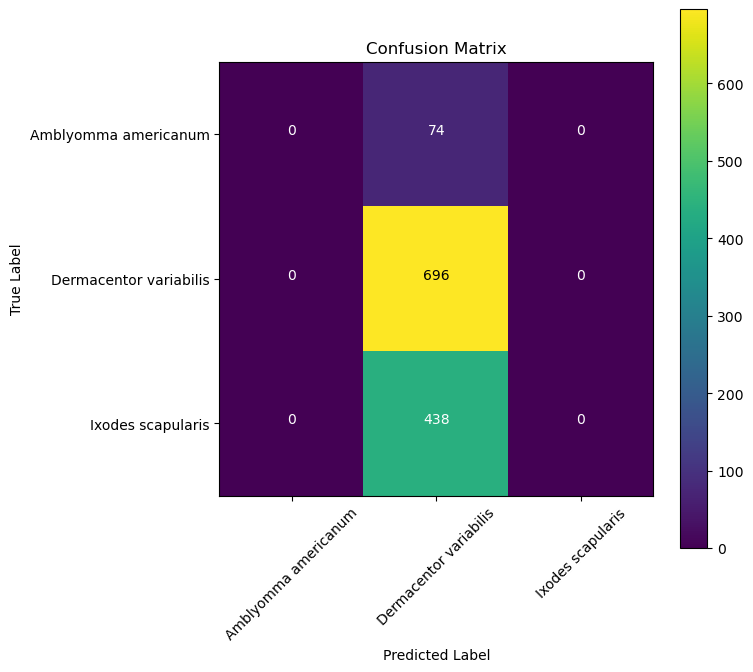

In [11]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.6018211920529801
                        precision    recall  f1-score   support

  Amblyomma americanum       0.13      0.05      0.08        74
Dermacentor variabilis       0.72      0.64      0.68       696
     Ixodes scapularis       0.50      0.63      0.56       438

              accuracy                           0.60      1208
             macro avg       0.45      0.44      0.44      1208
          weighted avg       0.60      0.60      0.60      1208



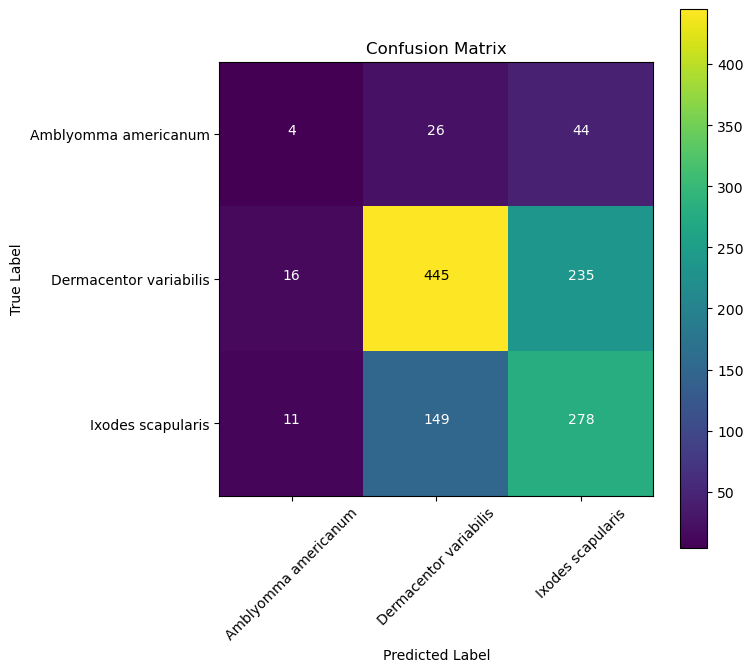

In [33]:
# Inception model classification report
clf_report(true_value, inception_pred)

ValueError: in user code:

    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 1024, 768, 3)


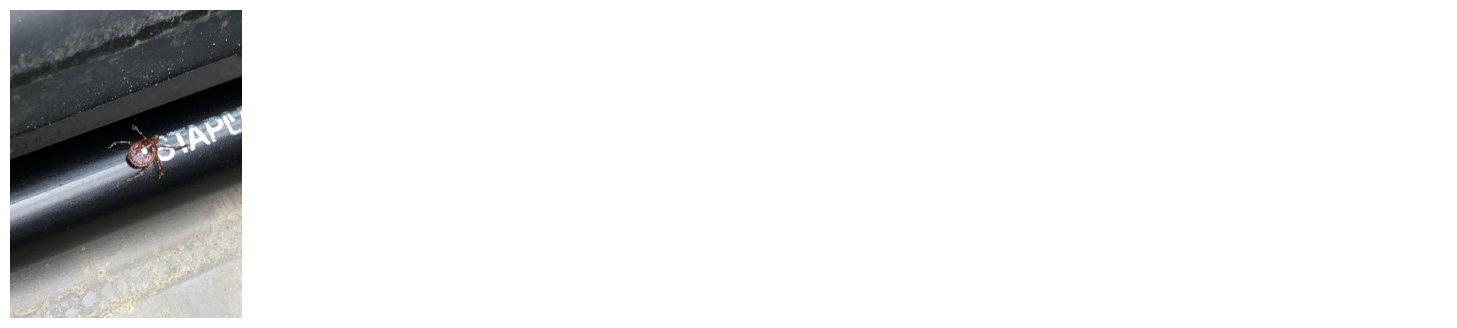

In [ ]:
show_few_images(1,benchmark_model_pred)

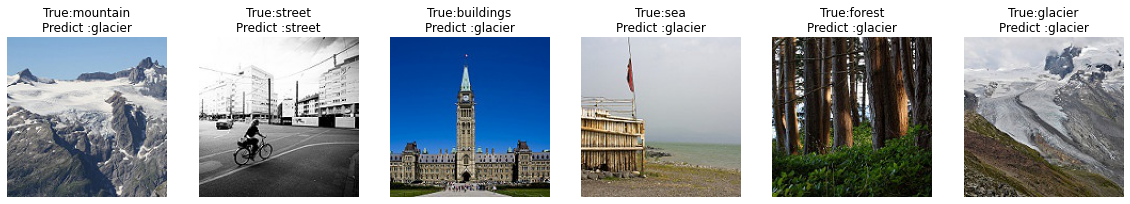

In [ ]:
show_few_images(1,vgg_pred)

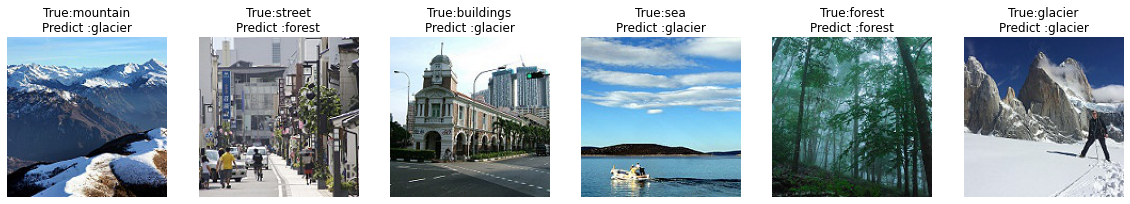

In [ ]:
show_few_images(1,resnet_pred)

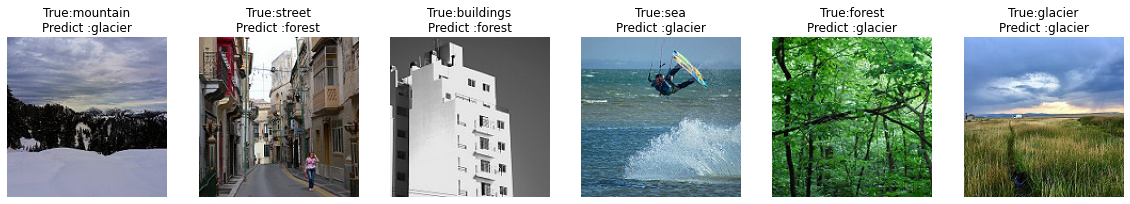

In [ ]:
show_few_images(1,inception_pred)

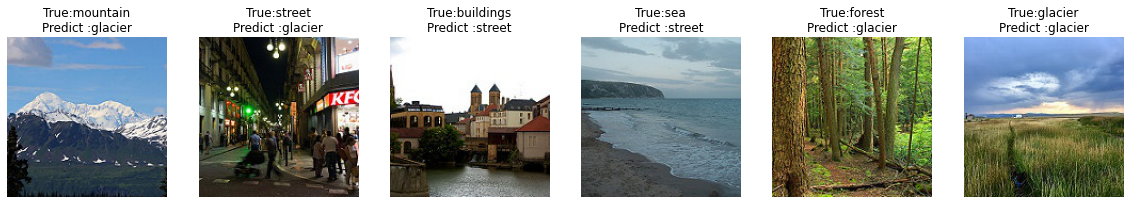

In [ ]:
show_few_images(1,combined_model_pred)